In [1]:
import pandas as pd
import matplotlib.pyplot as plt

### inlezen van data

In [14]:
# eerst laden we de dataset in 
df = pd.read_csv("../3dprinter/data.csv", sep = ';')
X = df.drop('tension_strength', axis = 'columns')
y = df.tension_strength
X.head()

,layer_height,wall_thickness,infill_density,infill_pattern,nozzle_temperature,bed_temperature,print_speed,material,fan_speed,roughness,elongation
0,0.02,8,90,0,220,60,40,0,0,25,1.2
1,0.02,7,90,1,225,65,40,0,25,32,1.4
2,0.02,1,80,0,230,70,40,0,50,40,0.8
3,0.02,4,70,1,240,75,40,0,75,68,0.5
4,0.02,6,90,0,250,80,40,0,100,92,0.7


### snel een regressie model maken

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error, r2_score

In [10]:
# functie om de R2 adjusted te berekenen
def R2adjusted(R2, n, p):
    return 1-(1-R2)*(n-1)/(n-p-1)

In [15]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=2)
# een lineaire regressie model maken
linreg = LinearRegression()
linreg.fit(x_train, y_train)

y_pred = linreg.predict(x_test)

In [16]:
print('MSE: ', mean_squared_error(y_test, y_pred))
R2 = r2_score(y_test, y_pred)
n = len(y_test)
p = len(x_test.columns)
R2adj = R2adjusted(R2, n, p)
print('R2: ', R2)
print('R2adj', R2adj)

MSE:  60.55173742301437
R2:  0.011884180433838654
R2adj -0.8242138207375287


Zoals we zien is de R2 erg slecht. We kunnen de correlatie coefficienten berekenen om te kijken of we last hebben van multicollineariteit.

In [17]:
# maakt de correlatie matrix
df.corr()

,layer_height,wall_thickness,infill_density,infill_pattern,nozzle_temperature,bed_temperature,print_speed,material,fan_speed,roughness,tension_strength,elongation
layer_height,1.000000e+00,-0.192571,3.498560e-03,0.000000,-1.780545e-17,-4.925818e-18,-0.055501,0.000000,7.881309e-18,0.801341,0.338230,0.507583
wall_thickness,-1.925714e-01,1.000000,1.025762e-01,0.145159,-1.184929e-01,-2.932662e-02,-0.419531,0.117510,-2.932662e-02,-0.226987,0.399849,0.176364
infill_density,3.498560e-03,0.102576,1.000000e+00,-0.167274,2.386137e-01,1.600823e-18,-0.094304,-0.262859,2.561317e-18,0.118389,0.358464,0.159009
infill_pattern,0.000000e+00,0.145159,-1.672736e-01,1.000000,-1.703995e-01,0.000000e+00,0.000000,0.200000,0.000000e+00,-0.068340,0.009054,0.046138
nozzle_temperature,-1.780545e-17,-0.118493,2.386137e-01,-0.170400,1.000000e+00,6.024534e-01,0.000000,-0.783838,6.024534e-01,0.348611,-0.405908,-0.527447
bed_temperature,-4.925818e-18,-0.029327,1.600823e-18,0.000000,6.024534e-01,1.000000e+00,0.000000,0.000000,1.000000e+00,0.192142,-0.252883,-0.300871
print_speed,-5.550085e-02,-0.419531,-9.430408e-02,0.000000,0.000000e+00,0.000000e+00,1.000000,0.000000,0.000000e+00,0.121066,-0.264590,-0.234052
material,0.000000e+00,0.117510,-2.628585e-01,0.200000,-7.838379e-01,0.000000e+00,0.000000,1.000000,0.000000e+00,-0.233173,0.289726,0.394737
fan_speed,7.881309e-18,-0.029327,2.561317e-18,0.000000,6.024534e-01,1.000000e+00,0.000000,0.000000,1.000000e+00,0.192142,-0.252883,-0.300871
roughness,8.013409e-01,-0.226987,1.183890e-01,-0.068340,3.486108e-01,1.921416e-01,0.121066,-0.233173,1.921416e-01,1.000000,0.051617,0.098962


Hoge correlaties die we kunnen vinden zijn bed temperature met fan speed, tension strength met elongation, roughness met layer height. We kunnen even wat eruit filteren door te kijken welke (absolute) correlaties hoger zijn dan 0.4.

In [18]:
df.corr()[abs(df.corr())>0.4]

,layer_height,wall_thickness,infill_density,infill_pattern,nozzle_temperature,bed_temperature,print_speed,material,fan_speed,roughness,tension_strength,elongation
layer_height,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.801341,NaN,0.507583
wall_thickness,NaN,1.000000,NaN,NaN,NaN,NaN,-0.419531,NaN,NaN,NaN,NaN,NaN
infill_density,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
infill_pattern,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
nozzle_temperature,NaN,NaN,NaN,NaN,1.000000,0.602453,NaN,-0.783838,0.602453,NaN,-0.405908,-0.527447
bed_temperature,NaN,NaN,NaN,NaN,0.602453,1.000000,NaN,NaN,1.000000,NaN,NaN,NaN
print_speed,NaN,-0.419531,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN
material,NaN,NaN,NaN,NaN,-0.783838,NaN,NaN,1.000000,NaN,NaN,NaN,NaN
fan_speed,NaN,NaN,NaN,NaN,0.602453,1.000000,NaN,NaN,1.000000,NaN,NaN,NaN
roughness,0.801341,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN


We kunnen de vif test doen om te kijken welke correlaties het hoogst zijn.

In [6]:
# we kunnen de join functie gebruiken om een list van strings aan elkaar te verbinden met ' + ' als seperator
print(X.columns)
' + '.join(list(X.columns))

Index(['layer_height', 'wall_thickness', 'infill_density', 'infill_pattern',
       'nozzle_temperature', 'bed_temperature', 'print_speed', 'material',
       'fan_speed', 'roughness', 'elongation'],
      dtype='object')


'layer_height + wall_thickness + infill_density + infill_pattern + nozzle_temperature + bed_temperature + print_speed + material + fan_speed + roughness + elongation'

### Uitvoeren van VIF test

In [19]:
from statsmodels.stats.outliers_influence import variance_inflation_factor 
from patsy import dmatrices 

# het eerste argument in dmatrices is 'y ~ X1 + X2 + ... '. Hier moet je y en X vervangen door de kolomnamen van je dataframe
y_vif, x_vif = dmatrices('tension_strength ~ ' + ' + '.join(list(X.columns)), data=df, return_type='dataframe') 

vif = pd.DataFrame() 
vif['variable'] = x_vif.columns 
vif['VIF'] = [variance_inflation_factor(x_vif.values, i) for i in range(x_vif.shape[1])]
vif

C:\Users\simch\.conda\envs\AIVE\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
C:\Users\simch\.conda\envs\AIVE\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


We zien hoge vif waardes. Dat betekent dat we wat kolommen moeten verwijderen. Probeer een aantal kolommen te verwijderen zodat alle vif waardes lager dan 5 zijn.

In [27]:
X = df.drop(['tension_strength'], axis = 'columns')
from statsmodels.stats.outliers_influence import variance_inflation_factor 
from patsy import dmatrices 

# het eerste argument in dmatrices is 'y ~ X1 + X2 + ... '. Hier moet je y en X vervangen door de kolomnamen van je dataframe
y_vif, x_vif = dmatrices('tension_strength ~ ' + ' + '.join(list(X.columns)), data=df, return_type='dataframe') 

vif = pd.DataFrame() 
vif['variable'] = x_vif.columns 
vif['VIF'] = [variance_inflation_factor(x_vif.values, i) for i in range(x_vif.shape[1])]
vif

C:\Users\simch\.conda\envs\AIVE\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
C:\Users\simch\.conda\envs\AIVE\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


,variable,VIF
0,Intercept,0.000000
1,layer_height,9.135254
2,wall_thickness,1.483681
3,infill_density,1.551519
4,infill_pattern,1.093557
5,nozzle_temperature,93.229213
6,bed_temperature,inf
7,print_speed,1.568547
8,material,48.882993
9,fan_speed,inf


### iteratief variabelen verwijderen voor betere R2adjusted

In [28]:
X = df.drop(['tension_strength', 'fan_speed', 'material', 'layer_height'], axis = 'columns')

In [30]:
# laten we eerst de data standardiseren
Z = (X-X.mean())/X.std()

In [31]:
# we can make a new 
x_train, x_test, y_train, y_test = train_test_split(Z, y, test_size=0.5, random_state=2)

In [32]:
linreg = LinearRegression()
linreg.fit(x_train, y_train)
y_pred = linreg.predict(x_test)

In [33]:
def R2adjusted(R2, n, p):
    return 1-(1-R2)*(n-1)/(n-p-1)

In [34]:
print('MSE: ', mean_squared_error(y_test, y_pred))
R2 = r2_score(y_test, y_pred)
n = len(y_test)
p = len(x_test.columns)
R2adj = R2adjusted(R2, n, p)
print('R2: ', R2)
print('R2adj', R2adj)

MSE:  16.489549288473874
R2:  0.7309146656580634
R2adj 0.5963719984870951


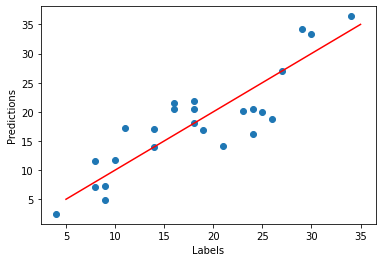

In [35]:
plt.scatter(y_test, y_pred)
plt.plot([5, 35], [5, 35], 'r')

plt.xlabel('Labels')
plt.ylabel('Predictions')

plt.show()

<BarContainer object of 8 artists>

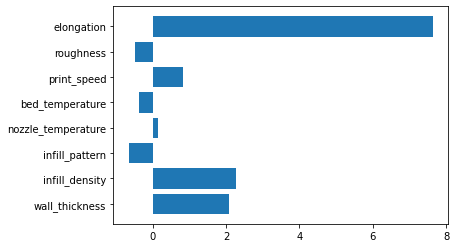

In [36]:
plt.barh(X.columns, linreg.coef_)

We can see that nozzle temperature does not add a lot of 'predictiveness'. We can remove that column

In [38]:
# preprocess data
X = df.drop(['tension_strength', 'fan_speed', 'material', 'layer_height', 'nozzle_temperature'], axis = 'columns')
Z = (X-X.mean())/X.std()
x_train, x_test, y_train, y_test = train_test_split(Z, y, test_size=0.5, random_state=2)

# make a linear regression model
linreg = LinearRegression()
linreg.fit(x_train, y_train)
y_pred = linreg.predict(x_test)

# calculate metrics
R2 = r2_score(y_test, y_pred)
n = len(y_test)
p = len(x_test.columns)
R2adj = R2adjusted(R2, n, p)
print('R2: ', R2)
print('R2adj', R2adj)

R2:  0.7330950455922278
R2adj 0.6231930055419688


We see a small increase in the R2adj. That is very good. How about the beta's?

<BarContainer object of 7 artists>

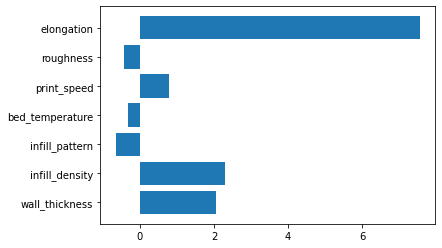

In [39]:
plt.barh(X.columns, linreg.coef_)

Roughness and bed temperature don't add a lot. We can also remove those

In [40]:
# preprocess data
X = df.drop(['tension_strength', 'fan_speed', 'material', 'layer_height', 'nozzle_temperature', 
             'bed_temperature', 'roughness'], axis = 'columns')
Z = (X-X.mean())/X.std()
x_train, x_test, y_train, y_test = train_test_split(Z, y, test_size=0.5, random_state=2)

# make a linear regression model
linreg = LinearRegression()
linreg.fit(x_train, y_train)
y_pred = linreg.predict(x_test)

# calculate metrics
R2 = r2_score(y_test, y_pred)
n = len(y_test)
p = len(x_test.columns)
R2adj = R2adjusted(R2, n, p)
print('R2: ', R2)
print('R2adj', R2adj)

R2:  0.7438840238479981
R2adj 0.6764850827553661


Now we see both a increase in the R2 and R2adj. Can you try to make this model better by removing more columns?